In [1]:
import jax
from jax import jit
from jax import lax
from jax import vmap
import jax.numpy as jnp

from functools import partial

jax.config.update('jax_enable_x64', True)

In [2]:
import math
import numpy as np
import plotly.express as px
import IPython
import matplotlib.pyplot as plt 
import ipywidgets as widgets

%config InlineBackend.figure_formats = ['svg']

In [3]:
from jax_control_algorithms.trajectory_optimization import Solver, constraint_geq, constraint_leq, unpack_res, plot_array_of_traces, plot_iterations
from jax_control_algorithms.ui import manual_investigate, solve_and_plot
from jax_control_algorithms.common import rk4

def make_time_vectors(X_opt, U_opt):
    # make time vectors
    t_X = jnp.linspace(0, X_opt.shape[0]-1, X_opt.shape[0])
    t_U = jnp.linspace(0, U_opt.shape[0]-1, U_opt.shape[0])
    
    return t_X, t_U

In [4]:
test_results = []

# Define the optimization problem: single-integrator dynamics

In [5]:
def problem_def_integrator(n_steps, dt):
        
    def model(x, u, k, theta):
        del k
        x_1,  = x

        a,   = theta['a'], 
        x_1_dot = jnp.squeeze(u) - a * x_1

        x_dot = jnp.array([
            x_1_dot,
        ])

        # cost
        J = theta['wu'] * u**2
        
        return x_dot, J

    def f(x, u, k, theta):
        x_dot, _ = model(x, u, k, theta)
        return x_dot

    def g(x, u, k, theta):
        
        x_dot, _ = model(x, u, k, theta)
        return 

    def running_cost(x, u, k, theta):
        
        x_dot, J  = model(x, u, k, theta)
        return J
        
    def terminal_state_eq_constraints(x_final, theta):
        x_1, = x_final
        
        return jnp.array([
            x_1 - theta['x_1_final'],           # != 0
        ])
    
    def inequ_constraints(x, u, k, theta):
        
        u = u[:,0]
        
        # constraints
        c_ineq = jnp.array([
            constraint_geq( u, theta['u_min'] ),
            constraint_leq( u, theta['u_max'] ),
            
        ])
        
        return c_ineq

    def make_guess(x0, theta):
                
        U_guess = jnp.zeros( (n_steps, 1) )
        X_guess = jnp.vstack((
            jnp.linspace( x0[0], theta['x_1_final'], n_steps),
        )).T
        
        return { 'X_guess' : X_guess, 'U_guess' : U_guess }
    
    theta = { 
        'a'             : 5.0, 
        'wu'            :  1.00,
        'u_min'         : -2.5,
        'u_max'         : 2.5,
        'x_1_final'     : 1.0,
    }
    
    
    x0 = jnp.array([ 0.0, ])
    
    #
    f_dscr = rk4(f, dt)

    problem_definition = {
        'f' : f_dscr,
        'g' : g,
        'running_cost' : running_cost,
        'terminal_state_eq_constraints': terminal_state_eq_constraints,
        'inequ_constraints' : inequ_constraints,
        'make_guess' : make_guess,
        'theta' : theta,
        'x0' : x0,
    }
    
    return problem_definition

def set_theta_fn(solver, a, u_min, u_max):
        solver.problem_definition['theta']['a'] = a
        solver.problem_definition['theta']['u_min'] = u_min
        solver.problem_definition['theta']['u_max'] = u_max


In [6]:
def plot_integrator(X_opt, U_opt, system_outputs, theta):

    # prepare data
    u = U_opt[:,0]
    x_1, =  X_opt[:,0], 

    _ = system_outputs # unpack output variable (return of function g)

    # make time vectors
    t_X, t_U = make_time_vectors(X_opt, U_opt)
    
    # Create a figure and two subplots
    fig, (ax1, ax2, ) = plt.subplots(2, 1, sharex=True, figsize=(4, 6))

    ax1.plot( t_X, x_1, 'k', label='x_1')
    ax1.plot(
        [ t_X[0], t_X[-1] ], 
        jnp.array([theta['x_1_final'], theta['x_1_final']]), 'k:',
        label='x_1_final'
    )
    
    ax1.legend()
    ax1.set_ylabel('x_1 []')
    ax1.set_title('integrator state')

    # 
    ax2.plot( t_U, u, 'k', label='u' )    
    ax2.plot(
        [ t_U[0], t_U[-1] ], 
        jnp.array([theta['u_min'], theta['u_min']]), ':k',
        label='u_min'
    )
    ax2.plot(
        [ t_U[0], t_U[-1] ], 
        jnp.array([theta['u_max'], theta['u_max']]), ':k',
        label='u_max'
    )
    
    ax2.legend()
    ax2.set_ylabel('u []')
    ax2.set_title('control variable')

    # Show the plot
    plt.show()

# Solve the optimization

compiling optimizer
👉 solving problem with n_horizon=50, n_states=1 n_inputs=1
🔄 it=0 	 (sub iter=64)	t/t_final = 0 %	eq_error/eq_tol = 95225 %	bounds ok: True
🔄 it=1 	 (sub iter=62)	t/t_final = 1 %	eq_error/eq_tol = 72651 %	bounds ok: True
🔄 it=2 	 (sub iter=67)	t/t_final = 1 %	eq_error/eq_tol = 52753 %	bounds ok: True
🔄 it=3 	 (sub iter=73)	t/t_final = 2 %	eq_error/eq_tol = 36677 %	bounds ok: True
🔄 it=4 	 (sub iter=75)	t/t_final = 3 %	eq_error/eq_tol = 24626 %	bounds ok: True
🔄 it=5 	 (sub iter=76)	t/t_final = 5 %	eq_error/eq_tol = 16086 %	bounds ok: True
🔄 it=6 	 (sub iter=76)	t/t_final = 8 %	eq_error/eq_tol = 10293 %	bounds ok: True
🔄 it=7 	 (sub iter=74)	t/t_final = 13 %	eq_error/eq_tol = 6498 %	bounds ok: True
🔄 it=8 	 (sub iter=76)	t/t_final = 21 %	eq_error/eq_tol = 4068 %	bounds ok: True
🔄 it=9 	 (sub iter=69)	t/t_final = 34 %	eq_error/eq_tol = 2537 %	bounds ok: True
🔄 it=10 	 (sub iter=64)	t/t_final = 55 %	eq_error/eq_tol = 1579 %	bounds ok: True
🔄 it=11 	 (sub iter=70)	t/t_f

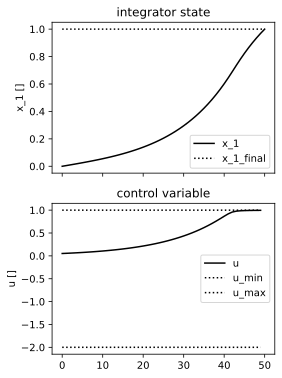

In [7]:
solver = Solver( partial(problem_def_integrator, n_steps = 50, dt=0.1) )

set_theta_fn(solver, a=0.7,  u_min=-2, u_max=1.0)
solver.verbose = True
X_opt, U_opt, system_outputs, res = solver.run()

# plot the results
plot_integrator(X_opt, U_opt, system_outputs, solver.problem_definition['theta'])

## investigate the convergence process

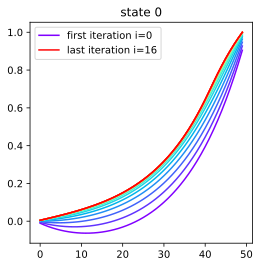

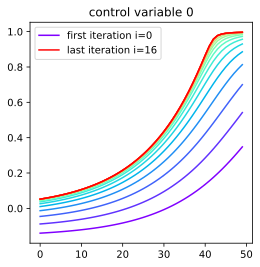

In [8]:
# show the convergence process
fig1, fig2 = plot_iterations(res, (4,4) )

# Manual investigation

In [9]:
sliders = {
        'a'     : widgets.FloatSlider(min=0.0,  max=1.0,  step=0.01,   value=0.7,  description='a'),
        'u_min' : widgets.FloatSlider(min=-2,  max=0,   step=0.01,  value=-2,   description='u_min'),
        'u_max' : widgets.FloatSlider(min=0,    max=2,  step=0.01,  value=1,    description='u_max'),
}

solver = Solver( partial(problem_def_integrator, n_steps = 50, dt=0.1) )
solver.solver_settings['max_float32_iterations'] = 0


In [10]:
def test_pendulum():
    # test
    set_theta_fn(solver, a=0.0,  u_min=-10, u_max=10)
    X_opt, U_opt, system_outputs, res = solver.run()    

In [11]:
ui, output_box, print_output, plot_output = manual_investigate(solver, sliders, set_theta_fn, plot_integrator )
display(ui, plot_output, print_output)

GridBox(children=(FloatSlider(value=0.7, description='a', max=1.0, step=0.01), FloatSlider(value=-2.0, descrip…

Output()

Output()

In [12]:
test_results.append( ['single integrator', solver.success ] )

# Double integrator

In [13]:
def problem_def_2integrator(n_steps, dt):
        
    def model(x, u, k, theta):
        del k
        x_1, X_2,  = x[0], x[1]

        a,   = theta['a'], 
        x_1_dot = jnp.squeeze(u) - a * x_1
        x_2_dot = x_1

        x_dot = jnp.array([
            x_1_dot, x_2_dot
        ])

        # cost + diff u
        J = theta['wu'] * u**2
        
        return x_dot, J

    def f(x, u, k, theta):
        x_dot, _ = model(x, u, k, theta)
        return x_dot

    def g(x, u, k, theta):
        
        x_dot, _ = model(x, u, k, theta)
        return 

    def running_cost(x, u, k, theta):
        
        x_dot, J  = model(x, u, k, theta)
        return J
        
    def terminal_state_eq_constraints(x_final, theta):
        
        return jnp.array([
            x_final[0] - theta['x_1_final'],           # != 0
            x_final[1] - theta['x_2_final'],           # != 0
        ])
    
    def inequ_constraints(x, u, k, theta):
        
        u = u[:,0]
        
        # constraints
        c_ineq = jnp.array([
            constraint_geq( u, theta['u_min'] ),
            constraint_leq( u, theta['u_max'] ),
            
        ])
        
        # x_dot, P_transmission, P_yield, J, c_ineq = model(x, u, k, theta)
        return c_ineq

    def make_guess(x0, theta):
                
        U_guess = jnp.zeros( (n_steps, 1) )
        X_guess = jnp.vstack((
            jnp.linspace( x0[0], theta['x_1_final'], n_steps),
            jnp.linspace( x0[1], theta['x_2_final'], n_steps),
        )).T
        
        return { 'X_guess' : X_guess, 'U_guess' : U_guess }
    
    theta = { 
        'a'             : 5.0, 
        'wu'            :  1.00,
        'u_min'         : -2.5,
        'u_max'         : 2.5,
        'x_1_final'     : 0.0,
        'x_2_final'     : 10.0,
    }
    
    
    x0 = jnp.array([ 0.0, 0.0 ])
    
    #
    f_dscr = rk4(f, dt)

    problem_definition = {
        'f' : f_dscr,
        'g' : g,
        'running_cost' : running_cost,
        'terminal_state_eq_constraints': terminal_state_eq_constraints,
        'inequ_constraints' : inequ_constraints,
        'make_guess' : make_guess,
        'theta' : theta,
        'x0' : x0,
    }
    
    return problem_definition

def set_theta_fn(solver, a, u_min, u_max):
        solver.problem_definition['theta']['a'] = a
        solver.problem_definition['theta']['u_min'] = u_min
        solver.problem_definition['theta']['u_max'] = u_max


In [14]:
def plot_2integrator(X_opt, U_opt, system_outputs, theta):

    # prepare data
    u = U_opt[:,0]
    x_1, x_2 =  X_opt[:,0], X_opt[:,1]

    _ = system_outputs # unpack output variable (return of function g)

    # make time vectors
    t_X, t_U = make_time_vectors(X_opt, U_opt)
    
    # Create a figure and two subplots
    fig, (ax1, ax2, ) = plt.subplots(2, 1, sharex=True, figsize=(4, 6))

    ax1.plot( t_X, x_1, 'r', label='x_1')
    ax1.plot( t_X, x_2, 'k', label='x_2')
    ax1.plot(
        [ t_X[0], t_X[-1] ], 
        jnp.array([theta['x_2_final'], theta['x_2_final']]), 'k:',
        label='x_2_final'
    )
    
    ax1.legend()
    ax1.set_ylabel('x_1 []')

    # 
    ax2.plot( t_U, u, 'k', label='u' )    
    ax2.plot(
        [ t_U[0], t_U[-1] ], 
        jnp.array([theta['u_min'], theta['u_min']]), ':k',
        label='u_min'
    )
    ax2.plot(
        [ t_U[0], t_U[-1] ], 
        jnp.array([theta['u_max'], theta['u_max']]), ':k',
        label='u_max'
    )
    
    ax2.legend()
    ax2.set_ylabel('u []')

    # Show the plot
    plt.show()

compiling optimizer
👉 solving problem with n_horizon=50, n_states=2 n_inputs=1
🔄 it=0 	 (sub iter=103)	t/t_final = 0 %	eq_error/eq_tol = 122516 %	bounds ok: True
🔄 it=1 	 (sub iter=98)	t/t_final = 1 %	eq_error/eq_tol = 106459 %	bounds ok: True
🔄 it=2 	 (sub iter=103)	t/t_final = 1 %	eq_error/eq_tol = 88129 %	bounds ok: True
🔄 it=3 	 (sub iter=108)	t/t_final = 2 %	eq_error/eq_tol = 69562 %	bounds ok: True
🔄 it=4 	 (sub iter=112)	t/t_final = 3 %	eq_error/eq_tol = 52026 %	bounds ok: True
🔄 it=5 	 (sub iter=118)	t/t_final = 5 %	eq_error/eq_tol = 37095 %	bounds ok: True
🔄 it=6 	 (sub iter=122)	t/t_final = 8 %	eq_error/eq_tol = 25473 %	bounds ok: True
🔄 it=7 	 (sub iter=125)	t/t_final = 13 %	eq_error/eq_tol = 17021 %	bounds ok: True
🔄 it=8 	 (sub iter=130)	t/t_final = 21 %	eq_error/eq_tol = 11156 %	bounds ok: True
🔄 it=9 	 (sub iter=128)	t/t_final = 34 %	eq_error/eq_tol = 7208 %	bounds ok: True
🔄 it=10 	 (sub iter=164)	t/t_final = 55 %	eq_error/eq_tol = 4607 %	bounds ok: True
🔄 it=11 	 (sub 

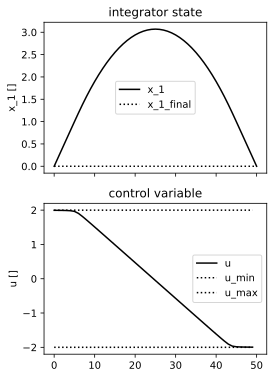

In [15]:
solver = Solver( partial(problem_def_2integrator, n_steps = 50, dt=0.1) )

set_theta_fn(solver, a=0.0,  u_min=-2, u_max=2)
solver.verbose = True
X_opt, U_opt, system_outputs, res = solver.run()

# plot the results
plot_integrator(X_opt, U_opt, system_outputs, solver.problem_definition['theta'])

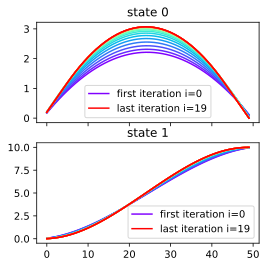

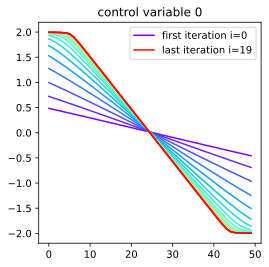

In [16]:
# show the convergence process
fig1, fig2 = plot_iterations(res, (4,4) )

In [17]:
sliders = {
        'a'     : widgets.FloatSlider(min=0.0,  max=1.0, step=0.01,  value=0.0,  description='a'),
        'u_min' : widgets.FloatSlider(min=-10,  max=0,   step=0.01,  value=-2,   description='u_min'),
        'u_max' : widgets.FloatSlider(min=0,    max=10,  step=0.01,  value=2,    description='u_max'),
}

solver = Solver( partial(problem_def_2integrator, n_steps = 50, dt=0.1) )
solver.solver_settings['max_float32_iterations'] = 0
solver.solver_settings['max_iter_boundary_method'] = 100
solver.solver_settings['c_eq_init'] = 1000



In [18]:
ui, output_box, print_output, plot_output = manual_investigate(solver, sliders, set_theta_fn, plot_2integrator )
display(ui, plot_output, print_output)

GridBox(children=(FloatSlider(value=0.0, description='a', max=1.0, step=0.01), FloatSlider(value=-2.0, descrip…

Output()

Output()

In [19]:
test_results.append( ['double integrator', solver.success ] )

### Re-run with different initial conditions

In [20]:
solver.problem_definition['x0'] = jnp.array( [0.1, 0.2] )
_ = solver.run()

👉 solving problem with n_horizon=50, n_states=2 n_inputs=1
🔄 it=0 	 (sub iter=133)	t/t_final = 0 %	eq_error/eq_tol = 45476 %	bounds ok: True
🔄 it=1 	 (sub iter=118)	t/t_final = 1 %	eq_error/eq_tol = 30622 %	bounds ok: True
🔄 it=2 	 (sub iter=123)	t/t_final = 1 %	eq_error/eq_tol = 19902 %	bounds ok: True
🔄 it=3 	 (sub iter=122)	t/t_final = 2 %	eq_error/eq_tol = 12629 %	bounds ok: True
🔄 it=4 	 (sub iter=122)	t/t_final = 3 %	eq_error/eq_tol = 7900 %	bounds ok: True
🔄 it=5 	 (sub iter=122)	t/t_final = 5 %	eq_error/eq_tol = 4906 %	bounds ok: True
🔄 it=6 	 (sub iter=117)	t/t_final = 8 %	eq_error/eq_tol = 3040 %	bounds ok: True
🔄 it=7 	 (sub iter=116)	t/t_final = 13 %	eq_error/eq_tol = 1883 %	bounds ok: True
🔄 it=8 	 (sub iter=119)	t/t_final = 21 %	eq_error/eq_tol = 1168 %	bounds ok: True
🔄 it=9 	 (sub iter=120)	t/t_final = 34 %	eq_error/eq_tol = 725 %	bounds ok: True
🔄 it=10 	 (sub iter=118)	t/t_final = 55 %	eq_error/eq_tol = 451 %	bounds ok: True
🔄 it=11 	 (sub iter=118)	t/t_final = 88 %	e

# Verify

In [21]:
def verify_test_results(test_results):
    for r in test_results:
        if not r[1]:
            raise BaseException('Test ' + r[0] + ' failed')
            
verify_test_results(test_results)